<a href="https://colab.research.google.com/github/Junseokee/Study-Python/blob/main/pythorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#데이콘 수화데이터 분류

##환경 설정 및 데이터 로드

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/dacon"
!unzip "user_data.zip"

In [42]:
import os
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu') #GPU 할당

In [43]:
#하이퍼 파라미터 튜닝
CFG = {
  'IMG_SIZE':128, #이미지 사이즈
  'EPOCHS':50, #에포크
  'LEARNING_RATE':2e-2, #학습률
  'BATCH_SIZE':12, #배치사이즈
  'SEED':41 #시드
}

In [44]:
import random
import numpy as np

In [45]:
# random seed 고정
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

In [46]:
import pandas as pd
label_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/train.csv')
label_df.head() #라벨 확인

,file_name,label
0,001.png,10-2
1,002.png,10-1
2,003.png,3
3,004.png,8
4,005.png,9


In [47]:
label_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  858 non-null    object
 1   label      858 non-null    object
dtypes: object(2)
memory usage: 13.5+ KB


##데이터 전처리

In [48]:
#10-1 10-2라벨을 10 과 0으로 변경
label_df['label'][label_df['label'] == '10-1'] = 10 ##label : 10-1 -> 10
label_df['label'][label_df['label'] == '10-2'] = 0
label_df['label'] = label_df['label'].apply(lambda x : int(x)) ##Dtype : object -> int

In [49]:
label_df.head()

,file_name,label
0,001.png,0
1,002.png,10
2,003.png,3
3,004.png,8
4,005.png,9


In [60]:
label_df.info() #label이 object -> int64로 변경

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  858 non-null    object
 1   label      858 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.5+ KB


In [76]:
#데이터 이미지의 local adress와 label 값을 list에 저장
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    #print('wow', img_path_list)
        
    # get label
    #label_df = pd.read_csv(data_dir+'/train.csv')
    label_list.extend(label_df['label'])
    #print('wow2', label_list)
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))
    #print(img_path_list)
    
    return img_path_list

In [78]:
all_img_path, all_label = get_train_data('/content/drive/MyDrive/Colab Notebooks/dacon/train')
test_img_path = get_test_data('/content/drive/MyDrive/Colab Notebooks/dacon/test')

In [79]:
all_label[0:7]

[0, 10, 3, 8, 9, 9, 8]

##DataSet 구성

In [80]:
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

In [81]:
# Train : Validation = 0.75 : 0.25 Split
train_len = int(len(all_img_path)*0.75)
Vali_len = int(len(all_img_path)*0.25)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

In [82]:
print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', Vali_len)

train set 길이 :  643
vaildation set 길이 :  214


In [83]:
train_transform = transforms.Compose([
                    transforms.ToPILImage(), #Numpy배열에서 PIL이미지로
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]), #이미지 사이즈 변형
                    transforms.ToTensor(), #이미지 데이터를 tensor
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #이미지 정규화
                    
                    ])

test_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize([CFG['IMG_SIZE'], CFG['IMG_SIZE']]),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    ])

In [84]:
# Get Dataloader

#CustomDataset class를 통하여 train dataset생성
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform) 
#만든 train dataset를 DataLoader에 넣어 batch 만들기
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) #BATCH_SIZE : 24

#vaildation 에서도 적용
vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

train_batches = len(train_loader)
vali_batches = len(vali_loader)

print('total train imgs :',train_len,'/ total train batches :', train_batches)
print('total valid imgs :',Vali_len, '/ total valid batches :', vali_batches)

total train imgs : 643 / total train batches : 54
total valid imgs : 214 / total valid batches : 18


In [85]:
train_batches = len(train_loader)
vali_batches = len(vali_loader)

print('total train imgs :',train_len,'/ total train batches :', train_batches)
print('total valid imgs :',Vali_len, '/ total valid batches :', vali_batches)

total train imgs : 643 / total train batches : 54
total valid imgs : 214 / total valid batches : 18


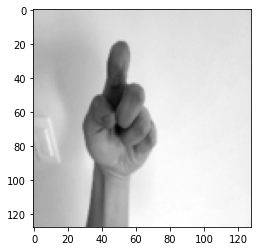

Label: 10


In [86]:
import cv2
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_loader)) #iter는 반복 가능한 객체에서 이터레이터를 반환하고, 
                                                        #next는 이터레이터에서 값을 차례대로 꺼냅니다. 
img = train_features[0]
label = train_labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {label}")

In [87]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Batch Labels shape: {train_labels}")

Feature batch shape: torch.Size([12, 3, 128, 128])
Batch Labels shape: tensor([10,  2,  9,  7,  6,  2,  4,  7,  1,  8,  0,  9])


In [88]:
from tqdm.auto import tqdm
import torch.nn as nn # 신경망들이 포함됨
#import torch.nn.init as init # 텐서에 초기값을 줌

class CNNclassification(torch.nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.fc_layer = nn.Sequential( 
            nn.Linear(3136, 11) #fully connected layer(ouput layer)
        )    
        
    def forward(self, x):
        
        x = self.layer1(x) #1층
        
        x = self.layer2(x) #2층
         
        x = self.layer3(x) #3층
        
        x = self.layer4(x) #4층
        
        x = torch.flatten(x, start_dim=1) # N차원 배열 -> 1차원 배열
        
        out = self.fc_layer(x)
        return out